In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# MAE считался стандартно (попарно), не на cumsum
from sklearn.metrics import mean_absolute_error

In [3]:
from darts import TimeSeries
from darts.models import AutoARIMA, LightGBMModel

In [4]:
# Поднастройка отображения графиков
sns.set(rc={'figure.figsize':(18,10)})
sns.set(font_scale=1.25)

In [5]:
##############################################################################################################################################################################################

In [6]:
# данные для обучения
#БЕ - Бизнес-единица, по отношению к которой проведена транзакция
#Дата транзакции - Дата совершения транзакции
#Cумма в RUB - Сумма транзакции, выраженная в рублях

data = pd.read_csv("train.csv")

In [7]:
train = pd.DataFrame()
train["Unit"] = data["БЕ"]
train["Date"] = data["Дата транзакции"]
train["RUB"] = data["Сумма в RUB"]

In [8]:
#Разбивка по бизнес единицам, для удобства рассмотрения
train_0 = train[train["Unit"]==0][["Date", "RUB"]]
train_0.set_index(pd.to_datetime(train_0["Date"]), inplace=True)
train_0.drop(["Date"], inplace=True, axis=1)

train_1 = train[train["Unit"]==1][["Date", "RUB"]]
train_1.set_index(pd.to_datetime(train_1["Date"]), inplace=True)
train_1.drop(["Date"], inplace=True, axis=1)

train_2 = train[train["Unit"]==2][["Date", "RUB"]]
train_2.set_index(pd.to_datetime(train_2["Date"]), inplace=True)
train_2.drop(["Date"], inplace=True, axis=1)

train_3 = train[train["Unit"]==3][["Date", "RUB"]]
train_3.set_index(pd.to_datetime(train_3["Date"]), inplace=True)
train_3.drop(["Date"], inplace=True, axis=1)

train_4 = train[train["Unit"]==4][["Date", "RUB"]]
train_4.set_index(pd.to_datetime(train_4["Date"]), inplace=True)
train_4.drop(["Date"], inplace=True, axis=1)

train_5 = train[train["Unit"]==5][["Date", "RUB"]]
train_5.set_index(pd.to_datetime(train_5["Date"]), inplace=True)
train_5.drop(["Date"], inplace=True, axis=1)

train_6 = train[train["Unit"]==6][["Date", "RUB"]]
train_6.set_index(pd.to_datetime(train_6["Date"]), inplace=True)
train_6.drop(["Date"], inplace=True, axis=1)

In [9]:
# Подправленные данные из-за дупликация в датах. То есть в одной дате прячется 2 транзакции. Просуммируем их. Только для Unit == 0
train_0d = train_0.groupby(train_0.index).sum()

In [10]:
# Нормализированная форма
train_0d

,RUB
Date,
2017-01-10,-3.715272e+08
2017-01-17,-5.362899e+08
2017-01-19,-1.578551e+05
2017-01-24,-3.473384e+08
2017-01-25,-2.208060e+06
...,...
2020-12-17,-7.787049e+05
2020-12-22,-3.983576e+08
2020-12-23,-1.932496e+07


In [11]:
# Делаем постоянное разрешение в 1 день и заполняем 0 появившиеся даты
train_0d_1d = train_0d.resample('1D').sum()

In [12]:
# Обрезаем данные, причина указана в презентации (сильно различие в ряде)
train_0d_1d_reindex = train_0d_1d.loc["2019-07-30":].reset_index(inplace=False)

In [13]:
# Перевод в формат, понятный darts
series_1d = TimeSeries.from_dataframe(train_0d_1d_reindex, time_col='Date', value_cols='RUB', freq='1d', fill_missing_dates=True)

In [14]:
# Трейн/валид для временного ряда
train_1d_split, val_1d_split = series_1d.split_before(0.80)

In [ ]:
# Самопальный gridsearch (а вообще есть встроенный). Почему 3 лага, почему output_chunk_length=180 - эвристически подобраны, совсем не факт, что оптимальные
best_result = np.inf
iteration = 0
best_params = {"j": 0, "k": 0, "z": 0}
for j in range(-1, -10, -2):
    for k in range(-1, -90, -3):
        for z in range(-1, -90, -6):
            model1d = LightGBMModel(lags=[j, k, z], output_chunk_length=180)
            model1d.fit(train_1d_split)
            prediction1d = model1d.predict(len(val_1d_split))
            fixed_prediction1d = prediction1d.pd_dataframe()
            current_result = mean_absolute_error(
                val_1d_split.pd_dataframe(), prediction1d.pd_dataframe()
            )
            iteration += 1
            if iteration % 10 == 0:
                print(f"{iteration} итерация")
            if current_result < best_result:
                print(f"New best result is {current_result}")
                best_result = current_result
                best_params["j"] = j
                best_params["k"] = k
                best_params["z"] = z
                print (f"best_params is {best_params.values()}")

In [ ]:
# Закончил проверку на 3000 итераций, их должно было быть больше; best_params = {'j': -9, 'k': -16, 'z': -31}
#best_params

In [15]:
#fit, predict
model1d = LightGBMModel(lags=[-9, -16, -31], output_chunk_length=180)
model1d.fit(train_1d_split)
prediction1d = model1d.predict(len(val_1d_split))

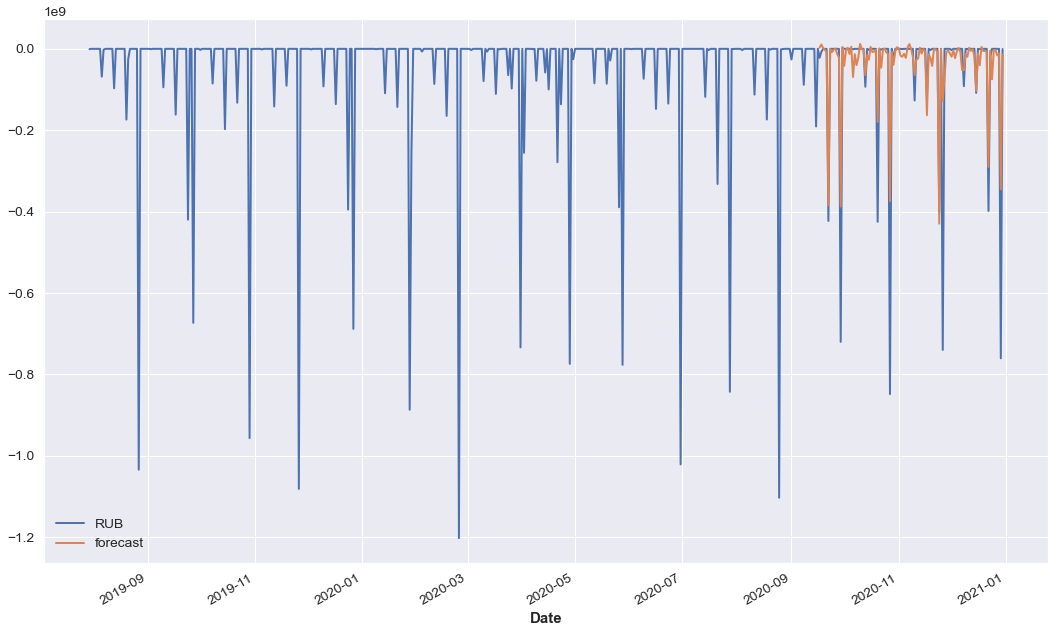

In [16]:
# Отрисовка для LightGBM, тут на глаз видно, что есть вылеты за 0 в положительную сторону, их принудительно обнуляем, т.к. (если правильно понял) у нас транзакции все в одну сторону
series_1d.plot()
prediction1d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [17]:
# Предварительный результат. НЕ ДЛЯ CUMSUM!
fixed_prediction1d = prediction1d.pd_dataframe()
mean_absolute_error(val_1d_split.pd_dataframe(), prediction1d.pd_dataframe())

34819851.34652423

In [18]:
# Настройка ARIMA модели на пиковые платежи.
# AUTOArima построена поверх библиотеки pmdarima для python

In [19]:
#Делаем шаг по времени 7 дней, все числа суммируем к "левому коренному" вторнику - closed='left'. Это допущение для модели, нужно было бы так же проверить "правые" вторники.
train_0d_7d = train_0d.reset_index().groupby(pd.Grouper(key='Date', freq='7D', how='sum', closed='left')).sum()

In [20]:
# Обрезаем неиспользуемое, аналогично предыдущей модели
train_0d_7d_reindex = train_0d_7d.loc["2019-07-30":].reset_index(inplace=False)

In [21]:
series_7d = TimeSeries.from_dataframe(train_0d_7d_reindex, time_col='Date', value_cols='RUB', freq='7d', fill_missing_dates=True)

In [22]:
train_7d_split, val_7d_split = series_7d.split_before(0.80)

In [23]:
model7d = AutoARIMA()
model7d.fit(train_7d_split)
prediction7d = model7d.predict(len(val_7d_split))

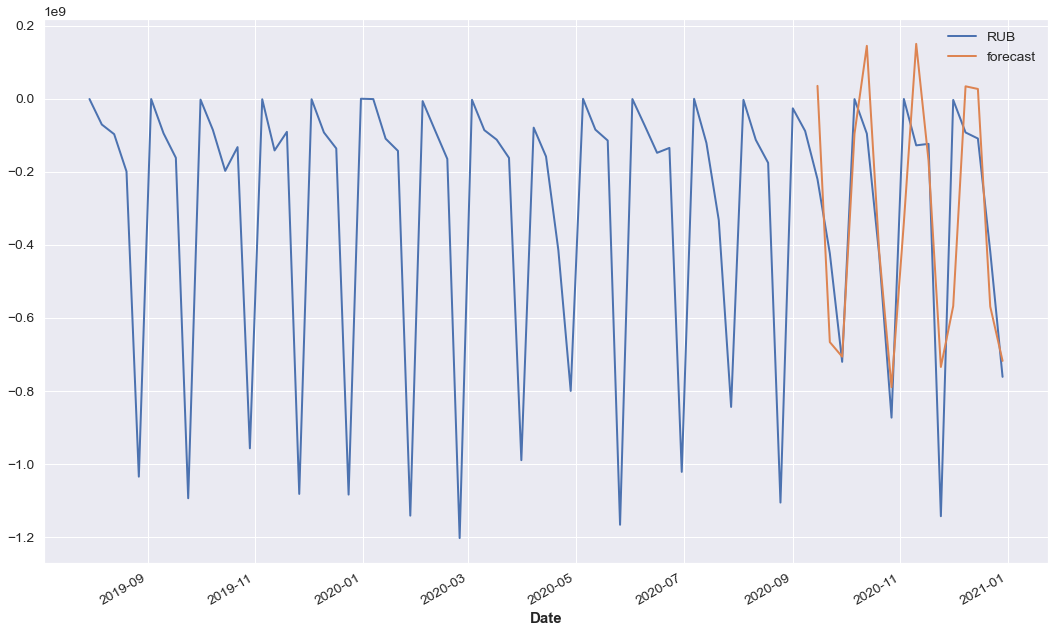

In [24]:
series_7d.plot()
prediction7d.plot(label='forecast', low_quantile=0.05, high_quantile=0.95)
plt.legend()

In [25]:
# НЕ CUMSUM
mean_absolute_error(val_7d_split.pd_dataframe(), prediction7d.pd_dataframe())

189400805.53771836

In [26]:
fixed_prediction7d = prediction7d.pd_dataframe()

In [27]:
# Ручная правка, т.к. положительных значений не может быть
fixed_prediction7d[fixed_prediction7d["RUB"]>0] = 0

In [28]:
mean_absolute_error(val_7d_split.pd_dataframe(), fixed_prediction7d)

164978372.7493938

In [29]:
# Ручная правка для предикта LightGBM модели
fixed_prediction1d[fixed_prediction1d["RUB"]>0] = 0 

In [30]:
# Взвешенная сумма двух моделей
mean_absolute_error(val_1d_split.pd_dataframe(), ((fixed_prediction1d["RUB"] + fixed_prediction7d.resample("1D").sum().loc["2020-09-17":]["RUB"])/2.15).fillna(0))

29996889.649154037

In [31]:
# График для val и predict

In [32]:
predict_series = ((fixed_prediction1d["RUB"] + fixed_prediction7d.resample("1D").sum().loc["2020-09-17":]["RUB"])/2.15).fillna(0)

In [33]:
val_df = pd.DataFrame()
val_df.index = predict_series.index
val_df["y"] = train_0d_1d.loc["2020-09-17":]
val_df["yhat"] = predict_series

In [34]:
val_df.head()

,y,yhat
Date,,
2020-09-17,-2.203722e+07,0.000000e+00
2020-09-18,-7.228353e+06,0.000000e+00
2020-09-19,0.000000e+00,0.000000e+00
2020-09-20,0.000000e+00,-1.138203e+06
2020-09-21,-2.519924e+05,-3.923033e+06


<AxesSubplot:xlabel='Date'>

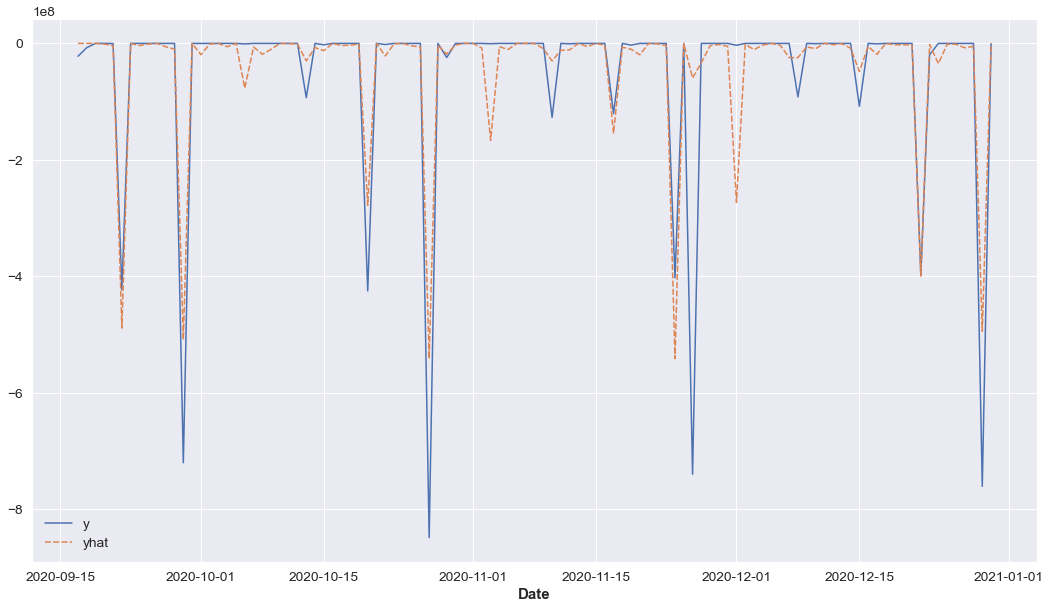

In [35]:
sns.lineplot(data=val_df)

In [36]:
# Predict на 2 квартала

In [37]:
# Делаем refit на полных данных для LightGBM
refit_model1d = LightGBMModel(lags=[-9, -16, -31], output_chunk_length=180)
refit_model1d.fit(series_1d)
refit_prediction1d = refit_model1d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1)

In [38]:
refit_prediction1d.pd_dataframe()

component,RUB
Date,
2020-12-31,-1.302648e+07
2021-01-01,-1.527025e+07
2021-01-02,-6.623533e+05
2021-01-03,-1.003751e+07
2021-01-04,1.459183e+06
...,...
2021-06-26,-3.351532e+07
2021-06-27,-4.951085e+07
2021-06-28,-2.128794e+06


In [39]:
# Предикт с разрешением в 1 день
refit_fixed_prediction1d = refit_prediction1d.pd_dataframe()
refit_fixed_prediction1d[refit_fixed_prediction1d["RUB"]>0] = 0
refit_fixed_prediction1d = refit_fixed_prediction1d.iloc[1:]

In [40]:
refit_fixed_prediction1d["RUB"]

Date
2021-01-01   -1.527025e+07
2021-01-02   -6.623533e+05
2021-01-03   -1.003751e+07
2021-01-04    0.000000e+00
2021-01-05   -7.337528e+07
                  ...     
2021-06-26   -3.351532e+07
2021-06-27   -4.951085e+07
2021-06-28   -2.128794e+06
2021-06-29   -1.302648e+07
2021-06-30   -1.527025e+07
Freq: D, Name: RUB, Length: 181, dtype: float64

In [41]:
# Делаем refit на полных данных для AUTOArima
model7d.fit(series_7d)
refit_prediction7d = model7d.predict(len(pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D"))+1)

In [42]:
refit_fixed_prediction7d = refit_prediction7d.pd_dataframe() # Принимаем форму стандартного датафрейма
refit_fixed_prediction7d[refit_fixed_prediction7d["RUB"]>0] = 0 # Ручная правка положительных значений

In [43]:
#Собираем предикт вместе
train_0_ans = pd.DataFrame()
#train_0_ans["Дата транзакции"] = pd.date_range(start="2021-01-05", end="2021-06-29", freq="7D") # legacy version
train_0_ans["Дата транзакции"] = pd.date_range(start="2021-01-01", end="2021-06-30", freq="1D")

train_0_ans["Сумма в RUB"] = pd.merge(train_0_ans, refit_fixed_prediction7d, how='outer', left_on=train_0_ans["Дата транзакции"], right_on=refit_fixed_prediction7d.index)["RUB"].fillna(0)
train_0_ans["Сумма в RUB"] += refit_fixed_prediction1d["RUB"].values
train_0_ans["Сумма в RUB"] /= 2.15
train_0_ans["Сумма в RUB"] = train_0_ans["Сумма в RUB"].groupby(train_0_ans["Дата транзакции"].dt.month).cumsum().values

train_0_ans["Месяц"] = train_0_ans["Дата транзакции"].dt.month
train_0_ans["БЕ"] = 0


In [44]:
train_0_ans.to_csv("train_0_ans.csv")

In [ ]:
# Для каждого файла пишется свой предикт, далее все предикты собираеются вместе в один файл в Predictor.ipynb